In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import skew
from scipy.stats import boxcox

from utils import accuracy
from utils import stratified_sampling

from utils import pipeline
from utils import apply_boxcox
from utils import standardize_data
from utils import one_hot_encode

from classification import LogisticRegression
from classification import LeastSquaresClassifier

plt.style.use('science')

# For figure aesthetics
plt.rcParams['mathtext.fontset'] = 'custom'  
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'  
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'  
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'  
plt.rcParams['font.size'] = 16
plt.rcParams['mathtext.fontset'] = 'stix'  
plt.rcParams['font.family'] = 'STIXGeneral' 

## Least Squares Classifier

In [2]:
df = pd.read_excel('./data/new_database_results.xls')
X = df.values[:, 1:-1].astype(float)
y_multi = df.values[:, -1].astype(float)
y_binary = []
for yi in y_multi:
    if yi in [1, 2, 3]:
        y_binary.append(-1)
    elif yi in [4, 5, 6, 7]:
        y_binary.append(1)
y_binary = np.array(y_binary)

In [3]:
n_folds = 10

### Binary Classification

#### Without preprocessing

In [75]:
reg = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 0.0]

In [85]:
mean_accs1 = []
std_accs1 = []
print('-' * (26 * 3 + 1))
print("|{:^25}|{:^25}|{:^25}|".format('Penalty', 'Mean Acc', 'Std Acc'))
for p in reg:
    accs = []
    for fold in range(n_folds):
        clf = LeastSquaresClassifier(penalty=p)
        Xtr, ytr, Xts, yts = stratified_sampling(X, y_binary, proportion=0.8)
        clf.fit(Xtr, ytr)
        yp = clf.predict(Xts)
        yp = 2 * (1  * (yp > 0.0)) - 1
        acc = accuracy(yts, yp)
        accs.append(acc)
    mean_accs1.append(np.mean(accs))
    std_accs1.append(np.std(accs))
    print("|{:^25}|{:^25}|{:^25}|".format(p, np.mean(accs), np.std(accs)))
print('-' * (26 * 3 + 1))

-------------------------------------------------------------------------------
|         Penalty         |        Mean Acc         |         Std Acc         |
|            1            |   0.9141304347826088    |  0.021711939516780618   |
|           0.1           |    0.919021739130435    |  0.015265839027378403   |
|          0.01           |   0.9168478260869565    |  0.017365810118120068   |
|          0.001          |   0.9266304347826086    |  0.020225863115139558   |
|         0.0001          |   0.9201086956521738    |  0.015947174729479565   |
|          1e-05          |   0.9195652173913043    |   0.01766095305355645   |
|          1e-06          |   0.9304347826086955    |   0.02353957372576925   |
|          1e-07          |   0.9211956521739129    |  0.013367797691574836   |
|           0.0           |   0.9255434782608696    |  0.015188248491828395   |
-------------------------------------------------------------------------------


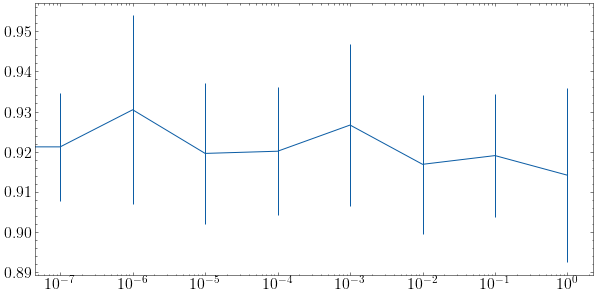

In [87]:
plt.figure(figsize=(10, 5))
plt.errorbar(reg, mean_accs1, std_accs1)
plt.xscale('log')

#### With Skewness correction and Standardization

In [88]:
mean_accs3 = []
std_accs3 = []
print('-' * (26 * 3 + 1))
print("|{:^25}|{:^25}|{:^25}|".format('Penalty', 'Mean Acc', 'Std Acc'))
for p in [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 0.0]:
    accs = []
    for fold in range(n_folds):
        clf = LeastSquaresClassifier(penalty=p)
        Xtr, ytr, Xts, yts = stratified_sampling(X, y_binary, proportion=0.8)
        Xtr = pipeline(Xtr, [apply_boxcox, standardize_data])
        Xts = pipeline(Xts, [apply_boxcox, standardize_data])
        clf.fit(Xtr, ytr)
        yp = clf.predict(Xts)
        yp = 2 * (1  * (yp > 0.0)) - 1
        acc = accuracy(yts, yp)
        accs.append(acc)
    mean_accs3.append(np.mean(accs))
    std_accs3.append(np.std(accs))
    print("|{:^25}|{:^25}|{:^25}|".format(p, np.mean(accs), np.std(accs)))
print('-' * (26 * 3 + 1))

-------------------------------------------------------------------------------
|         Penalty         |        Mean Acc         |         Std Acc         |
|            1            |   0.9271739130434783    |  0.012906893572867322   |
|           0.1           |   0.9369565217391305    |  0.013133745623472373   |
|          0.01           |   0.9201086956521738    |  0.011413043478260871   |
|          0.001          |          0.925          |  0.011605519839164479   |
|         0.0001          |   0.9233695652173914    |  0.017091505645126508   |
|          1e-05          |   0.9342391304347825    |  0.014265657335224658   |
|          1e-06          |   0.9260869565217392    |  0.019168687052769997   |
|          1e-07          |   0.9244565217391303    |  0.014057083865627809   |
|           0.0           |   0.9206521739130433    |  0.011190902327159788   |
-------------------------------------------------------------------------------


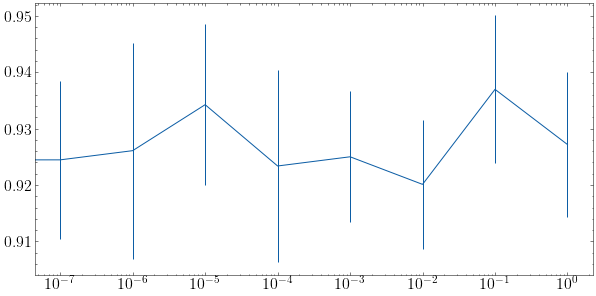

In [89]:
plt.figure(figsize=(10, 5))
plt.errorbar(reg, mean_accs3, std_accs3)
plt.xscale('log')

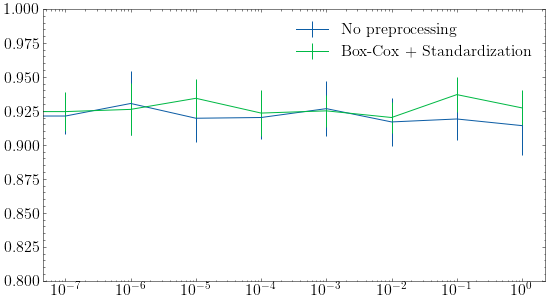

In [94]:
plt.figure(figsize=(9, 5))
plt.errorbar(reg, mean_accs1, std_accs1, label='No preprocessing')
plt.errorbar(reg, mean_accs3, std_accs3, label='Box-Cox + Standardization')
plt.xscale('log')
plt.ylim([0.8, 1.0])
plt.legend()

### Multi-Class Classification

#### Without Preprocessing

In [118]:
mean_accs1 = []
std_accs1 = []
print('-' * (26 * 3 + 1))
print("|{:^25}|{:^25}|{:^25}|".format('Penalty', 'Mean Acc', 'Std Acc'))
for p in reg:
    accs = []
    for fold in range(n_folds):
        clf = LeastSquaresClassifier(penalty=p)
        Xtr, ytr, Xts, yts = stratified_sampling(X, y_multi, proportion=0.8)
        ytr = one_hot_encode(ytr.astype(int) - 1, n_classes=7)
        yts = one_hot_encode(yts.astype(int) - 1, n_classes=7)
        clf.fit(Xtr, ytr)
        yp = clf.predict(Xts)
        acc = accuracy(yts.argmax(axis=1), yp.argmax(axis=1))
        accs.append(acc)
    mean_accs1.append(np.mean(accs))
    std_accs1.append(np.std(accs))
    print("|{:^25}|{:^25}|{:^25}|".format(p, np.mean(accs), np.std(accs)))
print('-' * (26 * 3 + 1))

-------------------------------------------------------------------------------
|         Penalty         |        Mean Acc         |         Std Acc         |
|            1            |   0.5661290322580645    |  0.022689191232267977   |
|           0.1           |   0.5806451612903226    |   0.02814247812538152   |
|          0.01           |   0.5876344086021505    |  0.028147613145609506   |
|          0.001          |   0.5817204301075269    |  0.027707739197258347   |
|         0.0001          |   0.5806451612903226    |   0.03243678092257712   |
|          1e-05          |   0.5790322580645162    |   0.03244123621837762   |
|          1e-06          |   0.5908602150537635    |   0.01959970551995504   |
|          1e-07          |   0.5795698924731183    |  0.021070879507812293   |
|           0.0           |   0.5752688172043012    |   0.02463750373632174   |
-------------------------------------------------------------------------------


#### Skewness correction

In [33]:
print('-' * (26 * 3 + 1))
print("|{:^25}|{:^25}|{:^25}|".format('Penalty', 'Mean Acc', 'Std Acc'))
for p in [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 0.0]:
    accs = []
    for fold in range(n_folds):
        clf = LeastSquaresClassifier(penalty=p)
        Xtr, ytr, Xts, yts = stratified_sampling(X, y_multi, proportion=0.8)
        ytr = one_hot_encode(ytr.astype(int) - 1, n_classes=7)
        yts = one_hot_encode(yts.astype(int) - 1, n_classes=7)
        Xtr = pipeline(Xtr, [apply_boxcox])
        Xts = pipeline(Xts, [apply_boxcox])
        clf.fit(Xtr, ytr)
        yp = clf.predict(Xts)
        acc = accuracy(yts.argmax(axis=1), yp.argmax(axis=1))
        accs.append(acc)
    print("|{:^25}|{:^25}|{:^25}|".format(p, np.mean(accs), np.std(accs)))
print('-' * (26 * 3 + 1))

-------------------------------------------------------------------------------
|         Penalty         |        Mean Acc         |         Std Acc         |
|            1            |   0.19193548387096776   |   0.08768716665101393   |
|           0.1           |    0.178494623655914    |   0.07004945150495627   |
|          0.01           |   0.2032258064516129    |   0.0472873837146151    |
|          0.001          |   0.1741935483870968    |   0.04957910487483227   |
|         0.0001          |   0.21559139784946235   |   0.08962383329768103   |
|          1e-05          |   0.19139784946236557   |   0.06059786152088331   |
|          1e-06          |   0.1978494623655914    |   0.06959406935606197   |
|          1e-07          |   0.1946236559139785    |   0.02863124076493408   |
|           0.0           |   0.1763440860215054    |  0.054975582929738566   |
-------------------------------------------------------------------------------


#### Standardization

In [100]:
print('-' * (26 * 3 + 1))
print("|{:^25}|{:^25}|{:^25}|".format('Penalty', 'Mean Acc', 'Std Acc'))
for p in [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 0.0]:
    accs = []
    for fold in range(n_folds):
        clf = LeastSquaresClassifier(penalty=p)
        Xtr, ytr, Xts, yts = stratified_sampling(X, y_multi, proportion=0.8)
        ytr = one_hot_encode(ytr.astype(int) - 1, n_classes=7)
        yts = one_hot_encode(yts.astype(int) - 1, n_classes=7)
        Xtr = pipeline(Xtr, [standardize_data])
        Xts = pipeline(Xts, [standardize_data])
        clf.fit(Xtr, ytr)
        yp = clf.predict(Xts)
        acc = accuracy(yts.argmax(axis=1), yp.argmax(axis=1))
        accs.append(acc)
    print("|{:^25}|{:^25}|{:^25}|".format(p, np.mean(accs), np.std(accs)))
print('-' * (26 * 3 + 1))

-------------------------------------------------------------------------------
|         Penalty         |        Mean Acc         |         Std Acc         |
|            1            |   0.5844086021505377    |  0.029255414753575907   |
|           0.1           |    0.588709677419355    |  0.019570187874409995   |
|          0.01           |   0.5903225806451613    |   0.03465970206728213   |
|          0.001          |    0.582258064516129    |  0.018786457214684044   |
|         0.0001          |    0.582258064516129    |  0.019091699897381416   |
|          1e-05          |   0.5913978494623657    |   0.02709592079215947   |
|          1e-06          |   0.5795698924731183    |  0.019204915160743845   |
|          1e-07          |   0.5865591397849462    |   0.03326823334280642   |
|           0.0           |   0.5827956989247312    |   0.02153224128440946   |
-------------------------------------------------------------------------------



#### Skewness correction + standardization

In [117]:
mean_accs3 = []
std_accs3 = []
print('-' * (26 * 3 + 1))
print("|{:^25}|{:^25}|{:^25}|".format('Penalty', 'Mean Acc', 'Std Acc'))
for p in reg:
    accs = []
    for fold in range(n_folds):
        clf = LeastSquaresClassifier(penalty=p)
        Xtr, ytr, Xts, yts = stratified_sampling(X, y_multi, proportion=0.8)
        ytr = one_hot_encode(ytr.astype(int) - 1, n_classes=7)
        yts = one_hot_encode(yts.astype(int) - 1, n_classes=7)
        Xtr = pipeline(Xtr, [apply_boxcox, standardize_data])
        Xts = pipeline(Xts, [apply_boxcox, standardize_data])
        clf.fit(Xtr, ytr)
        yp = clf.predict(Xts)
        acc = accuracy(yts.argmax(axis=1), yp.argmax(axis=1))
        accs.append(acc)
    mean_accs3.append(np.mean(accs))
    std_accs3.append(np.std(accs))
    print("|{:^25}|{:^25}|{:^25}|".format(p, np.mean(accs), np.std(accs)))
print('-' * (26 * 3 + 1))

-------------------------------------------------------------------------------
|         Penalty         |        Mean Acc         |         Std Acc         |
|            1            |   0.5903225806451614    |   0.02120761604657638   |
|           0.1           |   0.5887096774193549    |  0.028575660786921114   |
|          0.01           |   0.6000000000000001    |  0.029856867477236183   |
|          0.001          |    0.585483870967742    |  0.028085930938944056   |
|         0.0001          |   0.5897849462365592    |   0.0280447340983763    |
|          1e-05          |   0.5989247311827957    |  0.030903457770322385   |
|          1e-06          |    0.588709677419355    |   0.03173864977020527   |
|          1e-07          |   0.5763440860215054    |  0.022911049196411327   |
|           0.0           |   0.5967741935483871    |   0.03270302435644205   |
-------------------------------------------------------------------------------


In [112]:
len(mean_accs3)

9

In [116]:
std_accs3

[0.5956989247311828,
 0.5672043010752688,
 0.5935483870967742,
 0.5838709677419355,
 0.5962365591397849,
 0.5946236559139786,
 0.6026881720430108,
 0.6000000000000001,
 0.603225806451613]

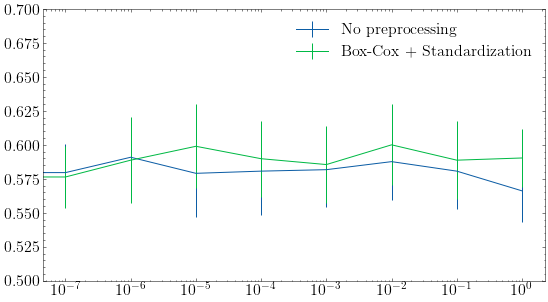

In [119]:
plt.figure(figsize=(9, 5))
plt.errorbar(reg, mean_accs1, std_accs1, label='No preprocessing')
plt.errorbar(reg, mean_accs3, std_accs3, label='Box-Cox + Standardization')
plt.xscale('log')
plt.ylim([0.5, 0.7])
plt.legend()

Text(0.5, 0, 'True Class')

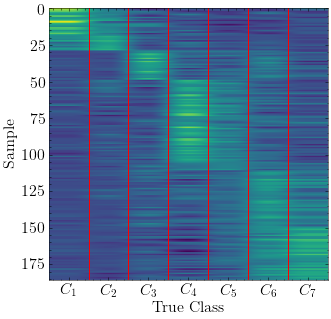

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(yp[yp.argmax(axis=1).argsort()], aspect='auto')
_ = ax.set_xticks([i for i in range(7)])
for i in range(7):
    ax.plot([0.5 + i] * len(yp), [i for i in range(len(yp))], color='r')
_ = ax.set_xticklabels(['$C_{' + str(i + 1) + '}$' for i in range(7)])
ax.set_ylabel('Sample')
ax.set_xlabel('True Class')

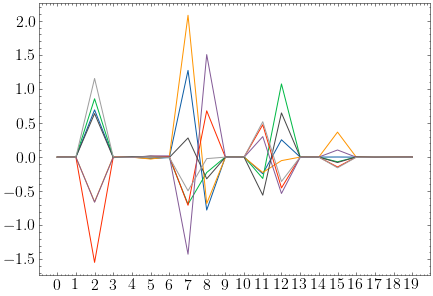

In [125]:
plt.figure(figsize=(7, 5))
plt.plot(clf.coefficients)
_ = plt.xticks([i for i in range(20)])

## Logistic Regression

In [4]:
clf = LogisticRegression(verbose=True, learning_rate=1e-3, n_epochs=400, momentum=0.999, penalty=1e-2, batch_size=64)
Xtr, ytr, Xts, yts = stratified_sampling(X, y_multi, proportion=0.8)
ytr = one_hot_encode(ytr.astype(int) - 1, n_classes=7)
yts = one_hot_encode(yts.astype(int) - 1, n_classes=7)
Xtr = pipeline(Xtr, [apply_boxcox, standardize_data])
Xts = pipeline(Xts, [apply_boxcox, standardize_data])
clf.fit(Xtr, ytr)

|           150           |    3.653786084002214    |   0.48579545454545453   |
|           151           |   3.6515672900493303    |   0.48579545454545453   |
|           152           |    3.649412832975978    |   0.48863636363636365   |
|           153           |   3.6473228082037483    |   0.4872159090909091    |
|           154           |    3.645297291676403    |   0.48863636363636365   |
|           155           |    3.643336340222197    |   0.4943181818181818    |
|           156           |    3.641439991929528    |   0.49573863636363635   |
|           157           |   3.6396082665350376    |   0.49573863636363635   |
|           158           |   3.6378411658232905    |   0.4971590909090909    |
|           159           |   3.6361386740370913    |   0.4971590909090909    |
|           160           |   3.6345007582975124    |   0.4971590909090909    |
|           161           |    3.632927369032679    |   0.49573863636363635   |
|           162           |   3.63141844

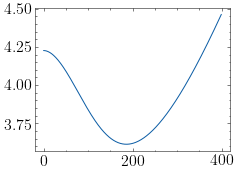

In [5]:
plt.plot(clf.history['loss'])

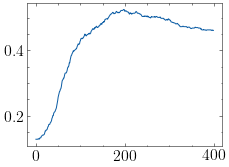

In [6]:
plt.plot(clf.history['acc'])

In [7]:
yp = clf.predict(Xts)
acc = accuracy(yts.argmax(axis=1), yp.argmax(axis=1))
print(acc)

0.46236559139784944


In [8]:
clf.best_epoch

197

Text(0.5, 0, 'True Class')

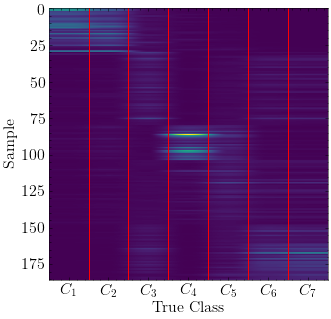

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(yp[yp.argmax(axis=1).argsort()], aspect='auto')
_ = ax.set_xticks([i for i in range(7)])
for i in range(7):
    ax.plot([0.5 + i] * len(yp), [i for i in range(len(yp))], color='r')
_ = ax.set_xticklabels(['$C_{' + str(i + 1) + '}$' for i in range(7)])
ax.set_ylabel('Sample')
ax.set_xlabel('True Class')

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
clf = LogisticRegression()

In [30]:
clf.fit(Xtr, ytr.argmax(axis=1))

/home/eduardo/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [31]:
yp = clf.predict(Xts)
acc = accuracy(yts.argmax(axis=1), yp)
print(acc)

0.6559139784946236
